In [1]:
import cbpro
import pprint
# importando modulos necesarios
import numpy as np
import pandas as pd
from datetime import datetime

from pydataset import data
import statsmodels.api as sm 

# librerías de visualizaciones
import seaborn as sns
import matplotlib.pyplot as plt

# pandas solo 4 decimales
pd.set_option('precision', 4)
public_client = cbpro.PublicClient()


df = pd.DataFrame(public_client.get_product_historic_rates('ETH-USD', granularity=86400), columns = [ 'time', 'Low', 'High', 'Open', 'Close', 'Volume' ]) 
df.index  = df['time'].apply(lambda x: datetime.fromtimestamp(x))

#df['Close'][1] / df['Close'][df.shape[0]-1] * 100



df['diff_Close'] = 1 - df['Close'].shift(periods=1) / df['Close']
df['target'] = (df['diff_Close'] > 0).astype('int') 
df


,time,Low,High,Open,Close,Volume,diff_Close,target
time,,,,,,,,
2021-02-18 01:00:00,1613606400,1851.47,1939.19,1851.90,1935.09,214434.3898,NaN,0
2021-02-17 01:00:00,1613520000,1733.87,1857.61,1782.14,1852.00,224624.7963,-0.0449,0
2021-02-16 01:00:00,1613433600,1725.00,1825.00,1780.59,1781.97,209801.2907,-0.0393,0
2021-02-15 01:00:00,1613347200,1659.93,1836.00,1803.25,1779.62,320429.9759,-0.0013,0
2021-02-14 01:00:00,1613260800,1785.07,1852.47,1817.85,1803.75,172443.9926,0.0134,1
...,...,...,...,...,...,...,...,...
2020-04-29 02:00:00,1588118400,196.64,219.59,196.64,215.66,377357.2933,0.0437,1
2020-04-28 02:00:00,1588032000,192.50,197.95,196.88,196.67,105608.4183,-0.0966,0
2020-04-27 02:00:00,1587945600,189.60,199.41,197.80,196.78,165535.9964,0.0006,1


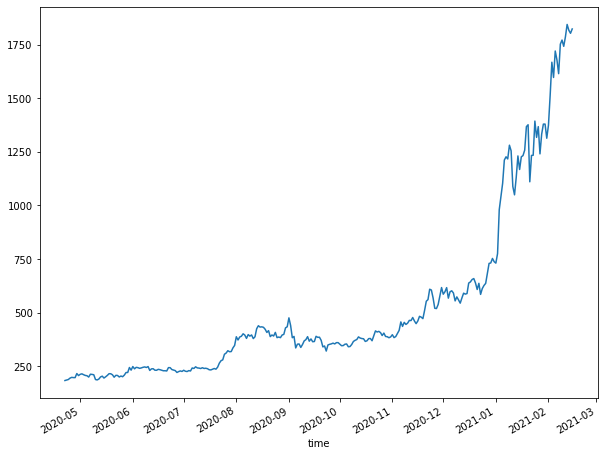

In [4]:
plot = df['Close'].plot(figsize=(10, 8))

In [3]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA, GOOG

def createStrategyClass(x, y):
    class SmaCross(Strategy):
        def init(self):
            price = self.data.Close
            self.ma1 = self.I(SMA, price, x)
            self.ma2 = self.I(SMA, price, y)

        def next(self):
            if crossover(self.ma1, self.ma2):
                self.position.close()
                self.buy()
            elif crossover(self.ma2, self.ma1):
                self.position.close()
                #self.sell()
    return SmaCross

x = 10
y = 30
StrategyClass = createStrategyClass(x,y)

bt = Backtest(df, StrategyClass, commission=.005, exclusive_orders=True)

stats = bt.run()
bt.plot()




In [4]:
stats

Start                     2020-04-25 02:00:00
End                       2021-02-18 01:00:00
Duration                    298 days 23:00:00
Exposure Time [%]                     61.6667
Equity Final [$]                   57636.8286
Equity Peak [$]                    57639.9286
Return [%]                           476.3683
Buy & Hold Return [%]                895.3143
Return (Ann.) [%]                    742.4001
Volatility (Ann.) [%]                776.1118
Sharpe Ratio                           0.9566
Sortino Ratio                         15.8917
Calmar Ratio                          20.6084
Max. Drawdown [%]                    -36.0242
Avg. Drawdown [%]                     -9.1759
Max. Drawdown Duration      101 days 00:00:00
Avg. Drawdown Duration       12 days 00:00:00
# Trades                                    3
Win Rate [%]                          66.6667
Best Trade [%]                       383.1755
Worst Trade [%]                       -26.174
Avg. Trade [%]                    

In [6]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

fspace = {
    'x': hp.quniform('x', 1, 100, q=1),
    'y': hp.quniform('y', 1, 100, q=1)
}

def f(params):
    x = int(params['x'])
    y = int(params['y'])
    StrategyClass = createStrategyClass(x,y)
 
    bt = Backtest(df, StrategyClass, commission=.002, exclusive_orders=True)
    stats = bt.run()
    val = (-1)*stats.values[5]
    return {'loss': val, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=f, space=fspace, algo=tpe.suggest, max_evals=100, trials=trials)

print(best)

100%|██████████| 100/100 [00:04<00:00, 21.48trial/s, best loss: -102002.13894]
{'x': 13.0, 'y': 28.0}
